In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import os
import sys

import pandas as pd

from keras.models import Model
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Add, Activation, Reshape, Permute
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.datasets import mnist, cifar10

In [0]:
def obtain(dir_path):
    """
    Downloads the dataset to ``dir_path``.
    """

    dir_path = os.path.expanduser(dir_path)
    print('Downloading the dataset')
    import urllib
    urllib.urlretrieve('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_train.amat',os.path.join(dir_path,'binarized_mnist_train.amat'))
    urllib.urlretrieve('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_valid.amat',os.path.join(dir_path,'binarized_mnist_valid.amat'))
    urllib.urlretrieve('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_test.amat',os.path.join(dir_path,'binarized_mnist_test.amat'))

    print('Done                     ')

# Model specifications

## Custom Layers

In [0]:
class MaskedConv2D(Conv2D):
    """
    Masked Convolution from [1]. Contains the same implementation of Conv2D from keras, but
    allows one to specify whether the mask type is 'A', 'B', or None. Some code taken from [2].
    
    Params
    ------
    
    mask_type: string, default=None
        Determines the masking type for the convolution from [1].
    
    References
    ----------
    
    [1] https://arxiv.org/pdf/1601.06759.pdf
    [2] https://github.com/jakebelew/gated-pixel-cnn/
    """
    
    def __init__(self, filters, kernel_size, channels=3, padding='same', mask_type=None, mask_rgb=True, **kwargs):
        self.mask_type = mask_type
        self.mask_rgb = mask_rgb
        self.num_data_channels = channels
        super(MaskedConv2D, self).__init__(filters, kernel_size, padding=padding, **kwargs)
        
    def build(self, input_shape):
        super(MaskedConv2D, self).build(input_shape)
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        # assert that the kernel size is odd
        assert self.kernel_size[0] % 2 == 1
        assert self.kernel_size[1] % 2 == 1
        
        center = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        self.mask = np.ones(kernel_shape)
        
        # mask out values right of center
        self.mask[center[0]:, center[1]+1:, :, :] = 0
        
        # mask out values below center
        self.mask[center[0]+1:, :, :, :] = 0
        
        # mask out center if masking type is 'A'
        if self.mask_type == 'A':
            self.mask[center[0], center[1], :, :] = 0
        
        # mask RGB channels
        mask_pixel = lambda i,j: i > j
        for i in range(input_dim):
            for j in range(self.filters):
                if mask_pixel(i % self.num_data_channels, j % self.num_data_channels) and self.mask_rgb:
                    self.mask[center[0], center[1], i, j] = 0
                
        self.mask = K.constant(self.mask)
        
    def call(self, inputs):
        if self.mask_type is None:
            return super(MaskedConv2D, self).call(inputs)
        outputs = K.conv2d(
            inputs,
            self.kernel * self.mask,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )
        if self.use_bias:
            outputs = K.bias_add(
            outputs,
            self.bias,
            data_format=self.data_format
            )
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [0]:
class ResidualBlock(object):
    
    def __init__(self, filters, channels=3, mask_rgb=True):
        self.filters = filters
        self.channels = channels
        self.mask_rgb = mask_rgb
        
    def __call__(self, model):
        block = Activation('relu')(model)
        block = MaskedConv2D(self.filters // 2, 1, mask_type='B', channels = self.channels, mask_rgb=self.mask_rgb, activation='relu')(block)
        block = MaskedConv2D(self.filters // 2, 3, mask_type='B', channels = self.channels, mask_rgb=self.mask_rgb, activation='relu')(block)
        block = MaskedConv2D(self.filters, 1, mask_type='B', channels = self.channels, mask_rgb=self.mask_rgb)(block)
        
        return Add()([model, block])

## Models

In [0]:
def pixel_cnn(input_shape, nb_features, nb_blocks, quantisations=256, mask_rgb=True):
    x = Input(shape=input_shape)
    if K.image_data_format() == 'channels_first':
        c, h, w = input_shape
    else:
        h, w, c = input_shape
    data_channels = c
    
    y = MaskedConv2D(nb_features, 7, channels=data_channels, mask_type='A', mask_rgb=mask_rgb)(x)

    for i in range(nb_blocks):
        y = ResidualBlock(nb_features, channels=data_channels, mask_rgb=mask_rgb)(y)

    # define output convs
    y = Activation('relu')(y)
    y = MaskedConv2D(nb_features, 1, channels=data_channels, mask_type='B', mask_rgb=mask_rgb)(y)
    y = Activation('relu')(y)
    
    if data_channels == 1:
        y = MaskedConv2D(1, 1, channels=data_channels, mask_type='B', mask_rgb=mask_rgb)(y)
        y = Activation('sigmoid')(y)    
    else:
        y = MaskedConv2D(quantisations * data_channels, 1, channels=data_channels, mask_type='B', mask_rgb=mask_rgb)(y)
        y = Reshape((h, w, quantisations, c))(y)
        y = Permute((1, 2, 4, 3))(y)
        y = Activation('softmax')(y)

    model = Model(x, y)
    
    return model

# Data

In [0]:
def load_binary_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = x_train/255.
    x_test = x_test/255.

    x_train = (x_train > np.random.rand(*x_train.shape)).astype(np.int32)
    x_test = (x_test > np.random.rand(*x_test.shape)).astype(np.int32)
    
    return (x_train, y_train), (x_test, y_test)

def load_color_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.repeat(np.expand_dims(x_train, -1), 3, axis=-1)
    x_test = np.repeat(np.expand_dims(x_test, -1), 3, axis=-1)
    x_train = x_train/255.
    x_test = x_test/255.
    
    return (x_train, y_train), (x_test, y_test)


def load_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train/255.
    x_test = x_test/255.
    
    return (x_train, y_train), (x_test, y_test)

In [0]:
def data_quantizer(data, batch_size=32, quantisations=256, shuffle=True):
    """
    Handles quantizing a batch of data from shape (H, W, C) to 
    (H, W, C, Q) where Q is the level of quantisation.
    
    Presumes the data is in the range [0, 1].
    """
    data = np.asarray(data)
    data = np.round(data * (quantisations-1))
    
    data = np.random.permutation(data) if shuffle else data
    
    total_steps = np.ceil(len(data) / batch_size)
    step = 0
    
    while True:
        batch = data[step*batch_size:(step+1)*batch_size]
        batch_q = to_categorical(batch, quantisations)
        batch = batch / (quantisations-1)
        
        step += 1
        
        if step >= total_steps:
            data = np.random.permutation(data) if shuffle else data
            step = 0
        
        yield batch, batch_q

# Training

In [10]:
(x_train, y_train), (x_test, y_test) = load_cifar10()

input_shape = x_train.shape[1:]
nb_channels = input_shape[-1]

model = pixel_cnn(input_shape, 128, 15)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
masked_conv2d_40 (MaskedConv2D) (None, 32, 32, 128)  18944       input_2[0][0]                    
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 32, 32, 128)  0           masked_conv2d_40[0][0]           
__________________________________________________________________________________________________
masked_conv2d_41 (MaskedConv2D) (None, 32, 32, 64)   8256        activation_16[0][0]              
__________________________________________________________________________________________________
masked_con

In [0]:
def binary_pixel_cnn_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2, -3))

def pixel_cnn_loss(y_true, y_pred):
    return K.mean(K.categorical_crossentropy(y_true, y_pred), axis=(-1, -2, -3, -4))

nb_regions = 4
regions = cumsum([3**i for i in range(nb_regions+1)]) + 100
schedule = lambda i, lr: 0.001 * 10**(-sum(regions <= i)/nb_regions)
lr_schedule = LearningRateScheduler(schedule)
checkpoint = ModelCheckpoint('./models/cifar10/model.hdf5', monitor='loss', verbose=1, save_best_only=True)

# epochs = regions[-1]
epochs = regions[-1]
batch_size = 100
steps_per_epoch = np.ceil(len(x_train) / batch_size)

gen = data_quantizer(x_train, batch_size=batch_size, quantisations=256)

model.compile(loss=pixel_cnn_loss, optimizer='adam')
model.fit_generator(gen, steps_per_epoch, epochs=epochs, callbacks=[lr_schedule, checkpoint])
# model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/221
 11/500 [..............................] - ETA: 8:45 - loss: 4.2314

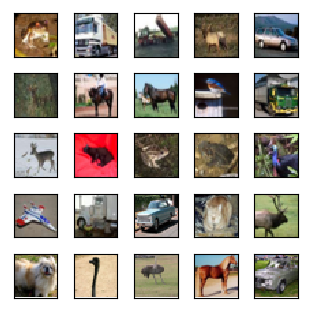

In [22]:
fig, axes = plt.subplots(5, 5, dpi=100, figsize=(3, 3), constrained_layout=True)
for i, ax in enumerate(axes):
    for j, a in enumerate(ax):
        a.imshow(x_train[i*10 + j])
        a.set_xticks(())
        a.set_yticks(())

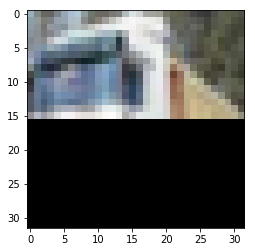

In [24]:
x_half = x_train[:100].copy()
x_half[:, 16:] = 0
imshow(x_half[1][:, :])

16 0 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 0 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 0 2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


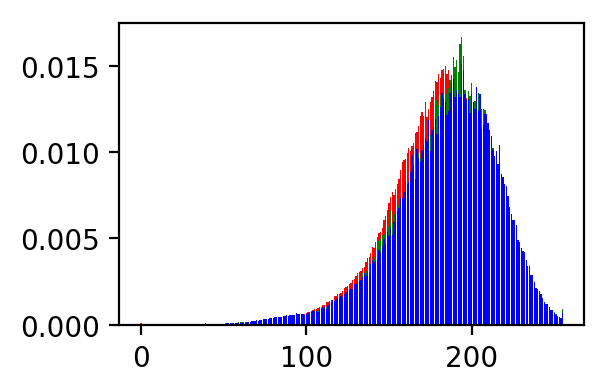

16 1 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 1 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 1 2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


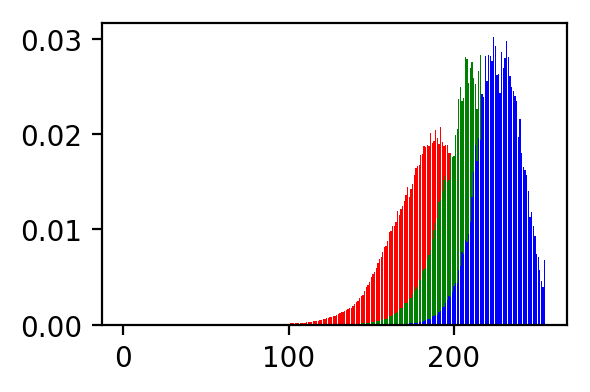

16 2 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 2 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 2 2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


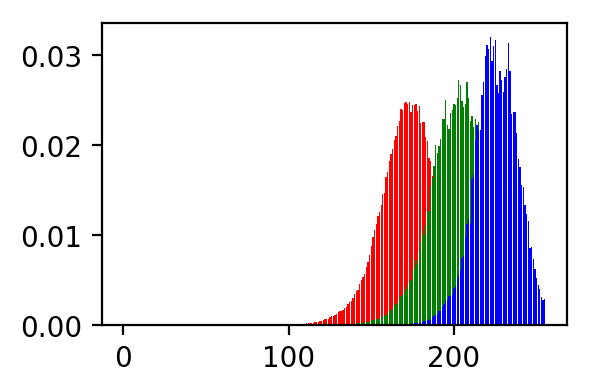

16 3 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 3 1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16 3 2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


KeyboardInterrupt: ignored

In [78]:
x_pred = np.repeat(np.expand_dims(x_half[1], 0), 25, axis=0)
for i in range(16, 32):
    for j in range(0, 32):
        fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
          for c in range(nb_channels):
            print(i, j, c)
            pred = model.predict(x_pred)
            green = pred[:, i, j, 1]
            print(green - pred[:, i, j, 1])
            ax.bar(range(256), pred[0, i, j, c], color=['r', 'g', 'b'][c])
            x_pred[:, i, j, c] = np.array([np.random.choice(list(range(256)), p=p) for p in pred[:, i, j, c]]) / 255.
        plt.show()
        

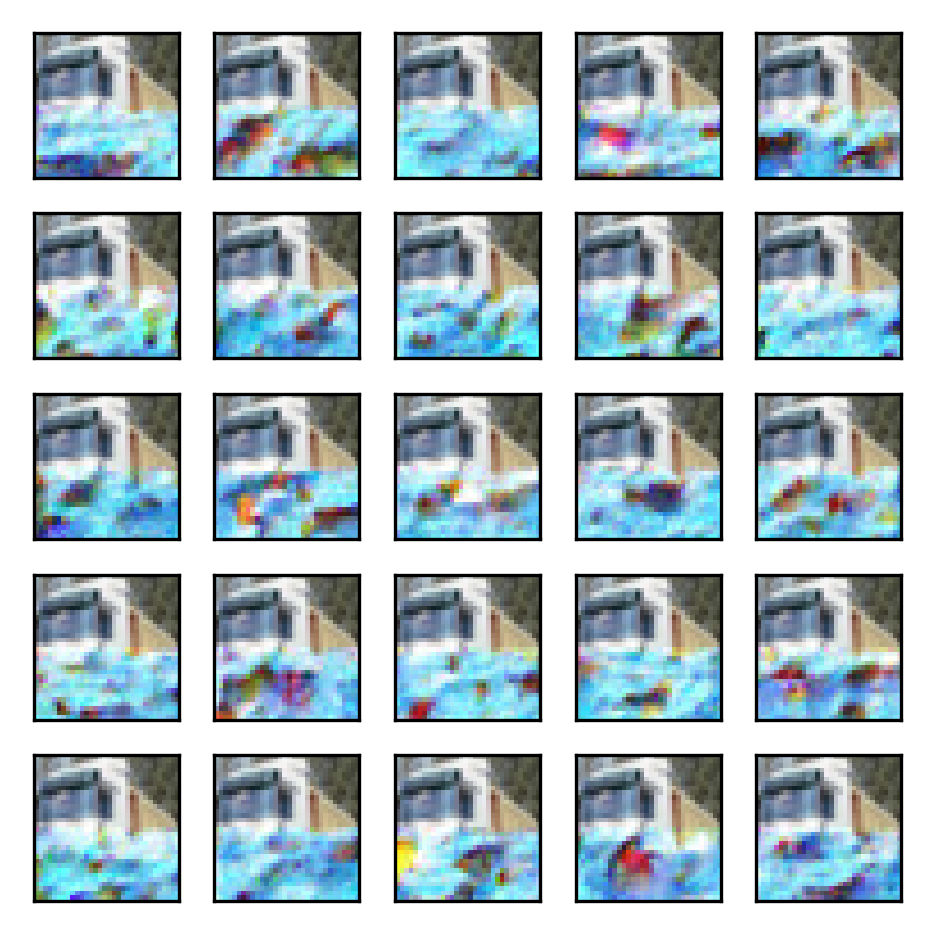

In [54]:
fig, axes = plt.subplots(5, 5, dpi=300, figsize=(3, 3), constrained_layout=True)

for i, ax in enumerate(axes):
    for j, a in enumerate(ax):
        a.imshow(x_pred[i*5 + j, :, :])
        a.set_xticks(())
        a.set_yticks(())

In [0]:
np.repeat?

In [0]:
mask_rgb=True
mask_type= 'B'

num_data_channels = 3

input_dim = 4
kernel_size = (3, 3)
filters = 6

kernel_shape = kernel_size + (input_dim, filters)

center = (kernel_size[0] // 2, kernel_size[1] // 2)
mask = np.ones(kernel_shape)

# mask out values right of center
mask[center[0]:, center[1]+1:, :, :] = 0

# mask out values below center
mask[center[0]+1:, :, :, :] = 0

# mask out center if masking type is 'A'
if mask_type == 'A':
    mask[center[0], center[1], :, :] = 0

# mask RGB channels
mask_pixel = lambda i,j: i > j
for i in range(input_dim):
    for j in range(filters):
        if mask_pixel(i % num_data_channels, j % num_data_channels) and mask_rgb:
            mask[center[0], center[1], i, j] = 0

<BarContainer object of 256 artists>

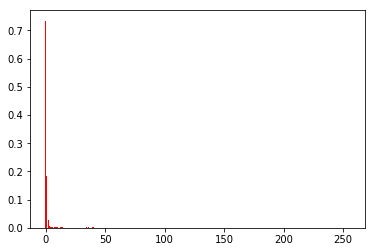

In [65]:
plt.bar(range(256), pred[0, i, j, 0], color=['r', 'g', 'b'][0])